# Cohort Analysis in Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading data

In [124]:
df = pd.read_csv('Transactions.csv', parse_dates=["tran_date"], infer_datetime_format=True)
df.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    23053 non-null  int64         
 1   cust_id           23053 non-null  int64         
 2   tran_date         23053 non-null  datetime64[ns]
 3   prod_subcat_code  23053 non-null  int64         
 4   prod_cat_code     23053 non-null  int64         
 5   Qty               23053 non-null  int64         
 6   Rate              23053 non-null  int64         
 7   Tax               23053 non-null  float64       
 8   total_amt         23053 non-null  float64       
 9   Store_type        23053 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 1.8+ MB


In [126]:
df.describe()

,transaction_id,cust_id,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt
count,2.305300e+04,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000
mean,5.007348e+10,271021.746497,6.149091,3.763632,2.432395,636.369713,248.667192,2107.308002
std,2.898194e+10,2431.692059,3.726372,1.677016,2.268406,622.363498,187.177773,2507.561264
min,3.268991e+06,266783.000000,1.000000,1.000000,-5.000000,-1499.000000,7.350000,-8270.925000
25%,2.493864e+10,268935.000000,3.000000,2.000000,1.000000,312.000000,98.280000,762.450000
50%,5.009313e+10,270980.000000,5.000000,4.000000,3.000000,710.000000,199.080000,1754.740000
75%,7.533000e+10,273114.000000,10.000000,5.000000,4.000000,1109.000000,365.715000,3569.150000
max,9.998755e+10,275265.000000,12.000000,6.000000,5.000000,1500.000000,787.500000,8287.500000


In [127]:
np.sum(df.Qty < 0)

2177

There are around 2k purchases with negative quantity, most likely returns. I will remove them from the dataset.

In [128]:
df = df[df['Qty'] > 0]

In [129]:
n_orders = df.groupby(['cust_id'])['transaction_id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['cust_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

90.72% of customers ordered more than once.


In [130]:
n_orders

cust_id
266783     4
266784     3
266785     7
266788     4
266794    11
          ..
275257     4
275261     3
275262     2
275264     2
275265     3
Name: transaction_id, Length: 5506, dtype: int64

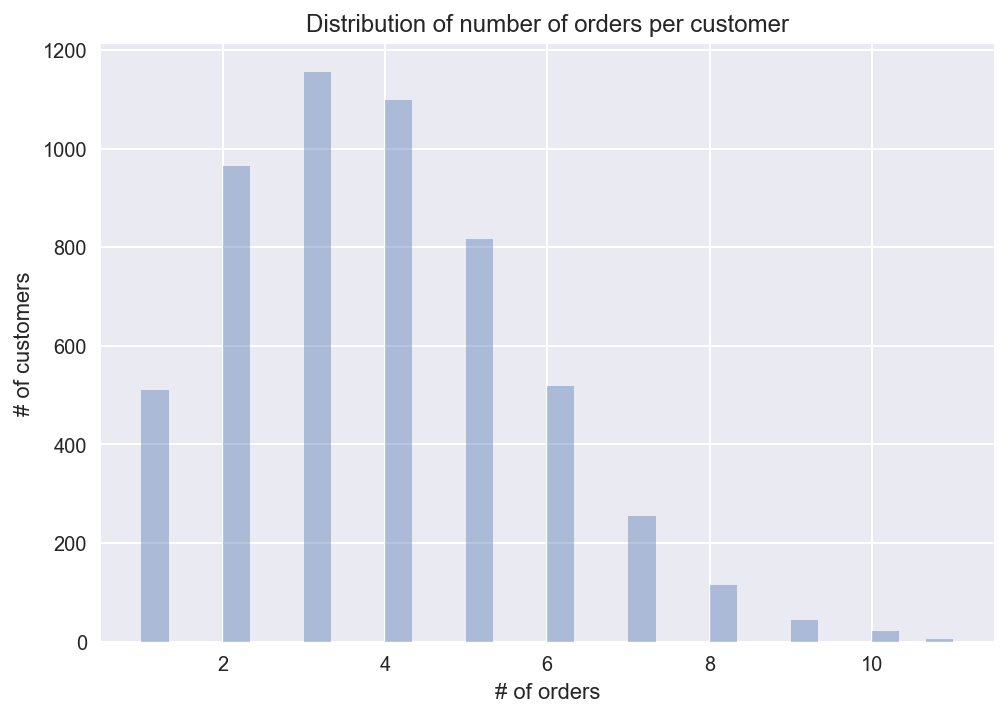

In [131]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

## Cohort analysis

In [153]:
# keep only the relevant data
df = df[['cust_id', 'transaction_id', 'tran_date']].drop_duplicates()

In [154]:
df.head()

,cust_id,transaction_id,tran_date
10,270384,29258453508,2014-02-20
11,267750,25455265351,2014-02-20
12,275023,1571002198,2014-02-20
14,269345,36554696014,2014-02-20
15,268799,56814940239,2014-02-20


In [155]:
# create two variables: month of order and cohort
df['order_month'] = df['tran_date'].dt.to_period('M')
df['cohort'] = df.groupby('cust_id')['tran_date'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [156]:
# add an indicator for periods (months since first purchase)
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('cust_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [157]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2011-01,2011-01,328,0
1,2011-01,2011-02,23,1
2,2011-01,2011-03,28,2
3,2011-01,2011-04,33,3
4,2011-01,2011-05,31,4
...,...,...,...,...
923,2014-07,2014-07,1,0
924,2014-08,2014-08,1,0
925,2014-10,2014-10,1,0
926,2014-11,2014-11,1,0


In [158]:
mask = (df_cohort['order_month'] >= '2011-01') & (df_cohort['order_month'] <= '2012-12')

In [159]:
df_cohort.loc[mask]

,cohort,order_month,n_customers,period_number
0,2011-01,2011-01,328,0
1,2011-01,2011-02,23,1
2,2011-01,2011-03,28,2
3,2011-01,2011-04,33,3
4,2011-01,2011-05,31,4
...,...,...,...,...
739,2012-10,2012-11,10,1
740,2012-10,2012-12,2,2
760,2012-11,2012-11,64,0
761,2012-11,2012-12,7,1


In [160]:
df_cohort = df_cohort.loc[mask]

In [161]:
# pivot the data into a form of the matrix
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [162]:
# divide by the cohort size (month 0) to obtain retention as %
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

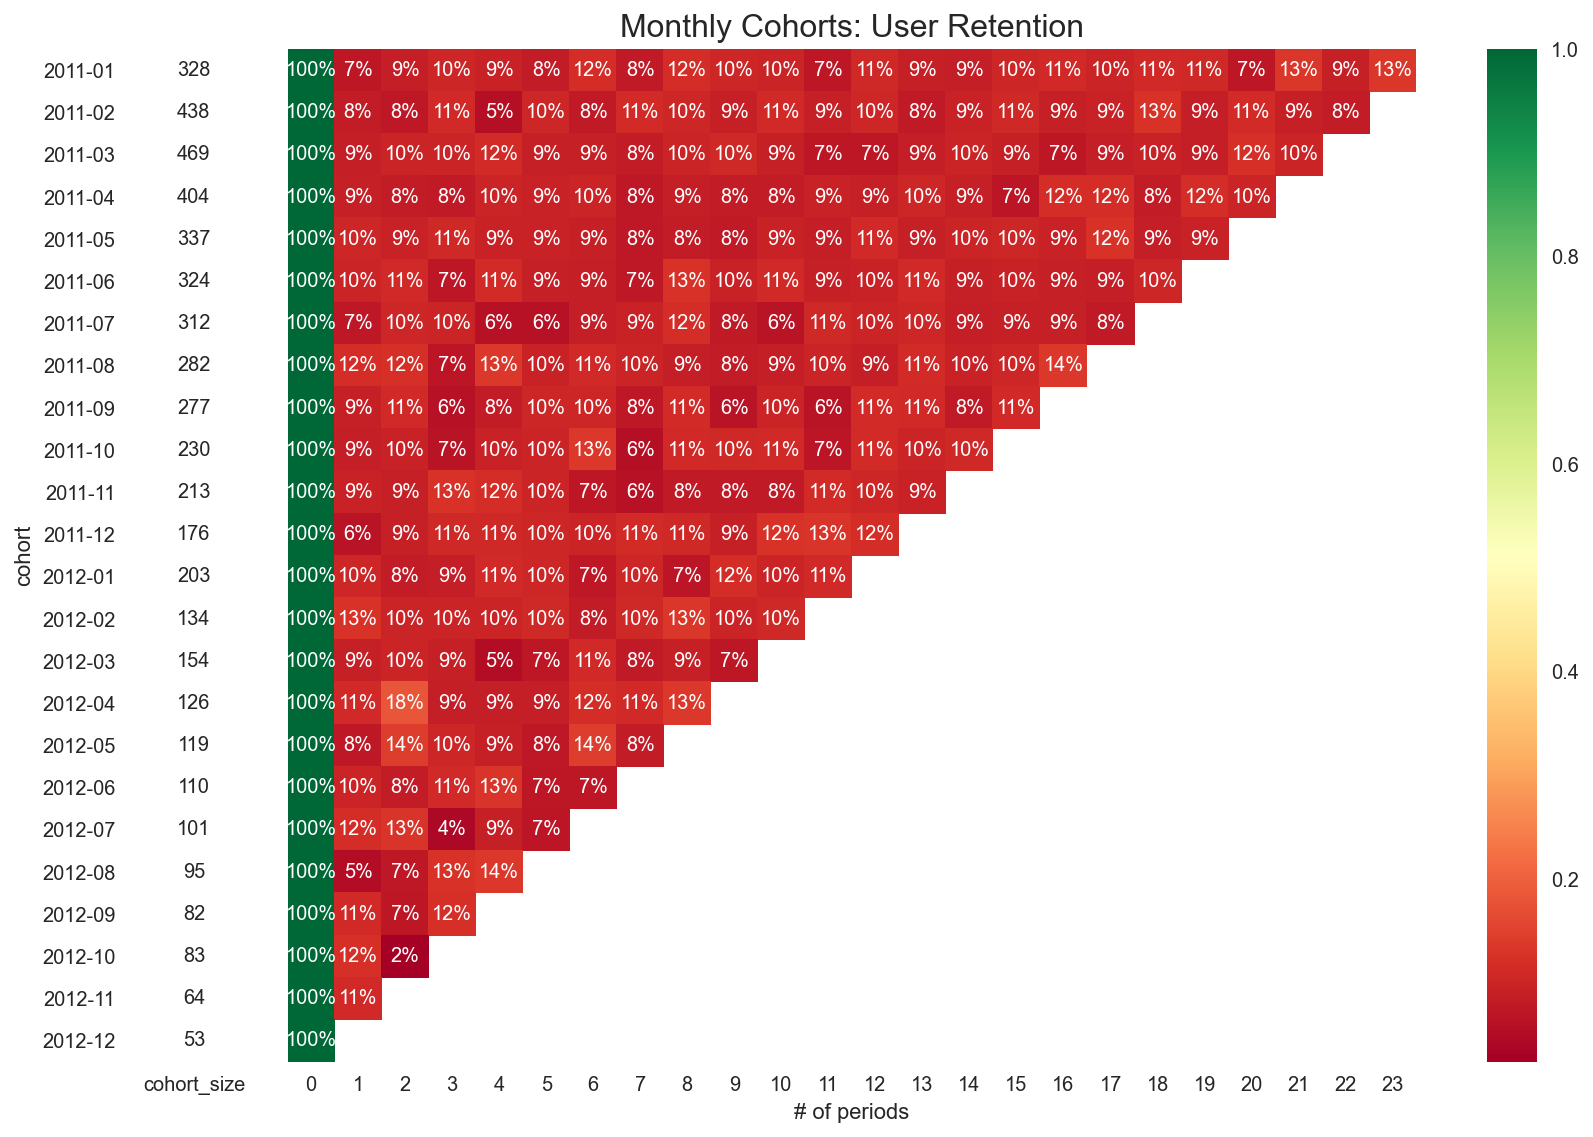

In [163]:
# plot the retention matrix

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()